# Part 1

Subway is looking to raise growth equity capital to further expand in Brazil. Our fund is looking to conduct outside-in diligence on the company to assess its current state and further opportunities in order to decide whether to participate in the process.
The fund would like you to evaluate the company and provide data-driven insights and recommendations. The base analysis should include the following:

    ● Current % coverage of Brazilian population & additional locations needed to cover additional 2% of the population

    ● Overlap with Mcdonald’s locations (i.e., % of locations with overlap within a 1-, 5-, 10-km radius)

In addition to the location analysis, you may choose to use additional data points or analyses to further your recommendations. Here are a few ideas of signals that we often look at, please note these are simply ideas of optional additions to your final analysis.

    ● Social media sentiment
    ● Employee sentiment
    ● Pricing / cost signals
    ● International opportunities
    ● Any additional factors you think that we should consider

Here are some sources to get you started:

    ● Databases provided in the “Data” folder along with this file. 
    ● https://www.ibge.gov.br

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import chardet
import re
import plotly.graph_objects as go
import folium
from folium import plugins
from geopy.geocoders import Nominatim
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import geodesic
import os
import ast
from transformers import pipeline
import praw
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import requests
from bs4 import BeautifulSoup


c:\Users\Santiago\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Datasets


In [2]:
subw_data = pd.read_csv('Subway_Locations.csv')
mc_data = pd.read_csv('Mcdonalds_Locations.csv')

### City Population
[Link Here](https://www.ibge.gov.br/estatisticas/downloads-estatisticas.html?caminho=Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios/Agregados_por_Municipio_csv/)

In [3]:
# Detect encoding
with open("pob_brasil_city.csv", "rb") as file:
    raw_data = file.read()
    result = chardet.detect(raw_data)
    encoding = result['encoding']
    print(f"Detected encoding: {encoding}")

Detected encoding: ISO-8859-1


In [4]:
pob_city = pd.read_csv('pob_brasil_city.csv',sep=";",encoding="ISO-8859-1")

## Preprocessing data

In [5]:
# Function to format data columns
def to_snake_case(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    s1 = s1.replace(' ','_')
    s2 = s1.replace('-','')
    s3 = s2.replace(',','')
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s3).lower()

def columns_transformer(data):
    columns=data.columns
    new_cols=[]
    for i in columns:
        i=to_snake_case(i)
        new_cols.append(i)
    data.columns=new_cols
    print(data.columns)
    return data

In [6]:

# Mapping of accented characters to unaccented counterparts
accented_to_unaccented = {
    'á': 'a', 'ã': 'a', 'à': 'a', 'â': 'a',
    'é': 'e', 'ê': 'e',
    'í': 'i',
    'ó': 'o', 'õ': 'o', 'ô': 'o',
    'ú': 'u',
    'ç': 'c',
    'Á': 'A', 'Ã': 'A', 'À': 'A', 'Â': 'A',
    'É': 'E', 'Ê': 'E',
    'Í': 'I',
    'Ó': 'O', 'Õ': 'O', 'Ô': 'O',
    'Ú': 'U',
    'Ç': 'C'
}

# Function to replace accented characters
def replace_accented(text):
    s1 = re.sub(r'[áãàâéêíóõôúçÁÃÀÂÉÊÍÓÕÔÚÇ]', 
                  lambda match: accented_to_unaccented[match.group(0)], 
                  text)
    s2 = s1.replace(' ','-')
    s3 = s2.replace("'","")
    s4 = s3.replace("-d-","-d")
    return s4.lower()

In [7]:
# Column transform to snake_case
subw_data = columns_transformer(subw_data)
pob_city = columns_transformer(pob_city)
mc_data = columns_transformer(mc_data)

Index(['unnamed:_0', 'code', 'name', 'maps__link', 'restaurant__link',
       'neighbour', 'city', 'state', 'data_address', 'address', 'tel'],
      dtype='object')
Index(['cd_mun', 'nm_mun', 'quantidade_de_moradores', 'sexo_masculino',
       'sexo_feminino', 'sexo_masculino_0_a_4_anos',
       'sexo_masculino_5_a_9_anos', 'sexo_masculino_10_a_14_anos',
       'sexo_masculino_15_a_19_anos', 'sexo_masculino_20_a_24_anos',
       'sexo_masculino_25_a_29_anos', 'sexo_masculino_30_a_39_anos',
       'sexo_masculino_40_a_49_anos', 'sexo_masculino_50_a_59_anos',
       'sexo_masculino_60_a_69_anos', 'sexo_masculino_70_anos_ou_mais',
       'sexo_feminino_0_a_4_anos', 'sexo_feminino_5_a_9_anos',
       'sexo_feminino_10_a_14_anos', 'sexo_feminino_15_a_19_anos',
       'sexo_feminino_20_a_24_anos', 'sexo_feminino_25_a_29_anos',
       'sexo_feminino_30_a_39_anos', 'sexo_feminino_40_a_49_anos',
       'sexo_feminino_50_a_59_anos', 'sexo_feminino_60_a_69_anos',
       'sexo_feminino_70_anos_ou_

### Subway Locations

In [8]:
subw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1625 entries, 0 to 1624
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   unnamed:_0        1625 non-null   int64 
 1   code              1625 non-null   int64 
 2   name              1625 non-null   object
 3   maps__link        1625 non-null   object
 4   restaurant__link  1625 non-null   object
 5   neighbour         1625 non-null   object
 6   city              1625 non-null   object
 7   state             1625 non-null   object
 8   data_address      1625 non-null   object
 9   address           1625 non-null   object
 10  tel               1484 non-null   object
dtypes: int64(2), object(9)
memory usage: 139.8+ KB


In [9]:
subw_data.drop(['unnamed:_0'],axis=1,inplace=True)

In [10]:
subw_data.duplicated().sum()

0

In [11]:
subw_data.isna().sum()

code                  0
name                  0
maps__link            0
restaurant__link      0
neighbour             0
city                  0
state                 0
data_address          0
address               0
tel                 141
dtype: int64

In [12]:
subw_data['city']=subw_data['city'].apply(replace_accented)

In [13]:
# Change tel column to boolean
subw_data['tel'].fillna(False)
def tel(data):
    if data!=False:
        return True
subw_data['tel']=subw_data['tel'].apply(tel)

In [14]:
# We change the city names that does not match
subw_data['city']=subw_data['city'].replace('cabo-de-sto-agostinho','cabo-de-santo-agostinho')
subw_data['city']=subw_data['city'].replace('igarussu','igarassu')
subw_data['city']=subw_data['city'].replace('monte-camelo','monte-carmelo')
subw_data['city']=subw_data['city'].replace('paraupebas','parauapebas')
subw_data['city']=subw_data['city'].replace('embu','embu-das-artes')

In [15]:
subw_data.head(5)

,code,name,maps__link,restaurant__link,neighbour,city,state,data_address,address,tel
0,41067,Subway Centro,https://maps.google.com/maps/dir/?api=1&destin...,https://restaurantes.subway.com/subway-centro-...,centro-santo-estevao-bahia,santo-estevao,bahia,avenida-getulio-vargas-s-n-centro-santo-esteva...,"Avenida Getúlio Vargas, S/...",True
1,41082,Subway Barra,https://maps.google.com/maps/dir/?api=1&destin...,https://restaurantes.subway.com/subway-barra-s...,barra-salvador-bahia,salvador,bahia,supermercado-bom-preco-2786-supermercado-bom-p...,"Supermercado Bom Preço, 27...",True
2,42701,Subway Centro,https://maps.google.com/maps/dir/?api=1&destin...,https://restaurantes.subway.com/subway-centro-...,centro-santo-antonio-de-jesus-bahia,santo-antonio-de-jesus,bahia,avenida-governador-roberto-santos-loja-166-ita...,Avenida Governador Roberto...,True
3,42714,Subway Centro,https://maps.google.com/maps/dir/?api=1&destin...,https://restaurantes.subway.com/subway-centro-...,centro-itabuna-bahia,itabuna,bahia,rua-professor-alicio-de-queiros-118a-centro-it...,Rua Professor Alício De Qu...,True
4,42699,Subway Centro,https://maps.google.com/maps/dir/?api=1&destin...,https://restaurantes.subway.com/subway-centro-...,centro-guanambi-bahia,guanambi,bahia,avenida-santos-dumont-terreo-centro-guanambi-b...,Avenida Santos Dumont - Té...,True


### McDonalds Locations

In [16]:
mc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160 entries, 0 to 1159
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   unnamed:_0          1160 non-null   int64  
 1   _id                 1160 non-null   object 
 2   active              1160 non-null   bool   
 3   name                1160 non-null   object 
 4   code                1160 non-null   object 
 5   coordinates         1160 non-null   object 
 6   country             1160 non-null   object 
 7   timezone            1160 non-null   object 
 8   address             1159 non-null   object 
 9   city                1155 non-null   object 
 10  neighborhood        1145 non-null   object 
 11  cep                 1093 non-null   object 
 12  services            1160 non-null   object 
 13  created_at          1160 non-null   object 
 14  updated_at          1160 non-null   object 
 15  time_slots_service  1160 non-null   object 
 16  genera

In [17]:
mc_data.isna().sum()

unnamed:_0             0
_id                    0
active                 0
name                   0
code                   0
coordinates            0
country                0
timezone               0
address                1
city                   5
neighborhood          15
cep                   67
services               0
created_at             0
updated_at             0
time_slots_service     0
general_hour           2
alias                 61
ecommerce              0
promotions             0
loyalty                0
distance               0
id                     0
siglas                 0
dtype: int64

In [18]:
mc_data.duplicated().sum()

0

In [19]:
mc_data['coordinates'] = mc_data['coordinates'].apply(ast.literal_eval)
mc_data['longitude'] = mc_data['coordinates'].apply(lambda x: x['longitude'])
mc_data['latitude'] = mc_data['coordinates'].apply(lambda x: x['latitude'])
mc_data.drop(['coordinates'],axis=1,inplace=True)

In [20]:
mc_data = mc_data.reset_index(drop=True).dropna()

In [21]:
mc_data.drop(['unnamed:_0'],axis=1,inplace=True)

In [22]:
mc_data['city']=mc_data['city'].apply(replace_accented)

### City Population

In [23]:
pob_city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   cd_mun                          5570 non-null   int64 
 1   nm_mun                          5570 non-null   object
 2   quantidade_de_moradores         5570 non-null   int64 
 3   sexo_masculino                  5570 non-null   int64 
 4   sexo_feminino                   5570 non-null   int64 
 5   sexo_masculino_0_a_4_anos       5570 non-null   int64 
 6   sexo_masculino_5_a_9_anos       5570 non-null   int64 
 7   sexo_masculino_10_a_14_anos     5570 non-null   int64 
 8   sexo_masculino_15_a_19_anos     5570 non-null   int64 
 9   sexo_masculino_20_a_24_anos     5570 non-null   int64 
 10  sexo_masculino_25_a_29_anos     5570 non-null   int64 
 11  sexo_masculino_30_a_39_anos     5570 non-null   int64 
 12  sexo_masculino_40_a_49_anos     5570 non-null   

In [24]:
# We keep columns with the name of the city and the population number. Besides that, we calculate the percentage
pob_city_acot = pob_city[['nm_mun','quantidade_de_moradores']]
pob_city_acot['percentage_pop'] = 100*pob_city_acot['quantidade_de_moradores']/sum(pob_city_acot['quantidade_de_moradores'])

C:\Users\Santiago\AppData\Local\Temp\ipykernel_19036\1868393727.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pob_city_acot['percentage_pop'] = 100*pob_city_acot['quantidade_de_moradores']/sum(pob_city_acot['quantidade_de_moradores'])


In [25]:
pob_city_acot.describe()

,quantidade_de_moradores,percentage_pop
count,5.570000e+03,5570.000000
mean,3.636654e+04,0.017953
std,2.061361e+05,0.101765
min,8.330000e+02,0.000411
25%,5.213250e+03,0.002574
50%,1.104550e+04,0.005453
75%,2.438750e+04,0.012040
max,1.144108e+07,5.648197


In [26]:
# We change the accents and the format of the cities
pob_city_acot['nm_mun']=pob_city_acot['nm_mun'].apply(replace_accented)

C:\Users\Santiago\AppData\Local\Temp\ipykernel_19036\4077112544.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pob_city_acot['nm_mun']=pob_city_acot['nm_mun'].apply(replace_accented)


## EDA

### Percentage of the population covered per city

In [27]:
#Groupby the cities to plot data
subw_data_city = subw_data.groupby(['city'])['code'].count().reset_index()
subw_data_city_pop = subw_data_city.merge(pob_city_acot,how='left',left_on='city',right_on='nm_mun')
total=pd.DataFrame({'city':'total','percentage_pop':[subw_data_city_pop['percentage_pop'].sum()]})
subw_data_city_pop=pd.concat([subw_data_city_pop,total])
subw_data_city_top=subw_data_city_pop.sort_values(by='percentage_pop',ascending=False).head(10)

In [28]:
subw_data_city_top=subw_data_city_top.drop(['code'],axis=1)

C:\Users\Santiago\AppData\Local\Temp\ipykernel_19036\1504473814.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subw_data_city_top['city'], rotation=45, ha='right')


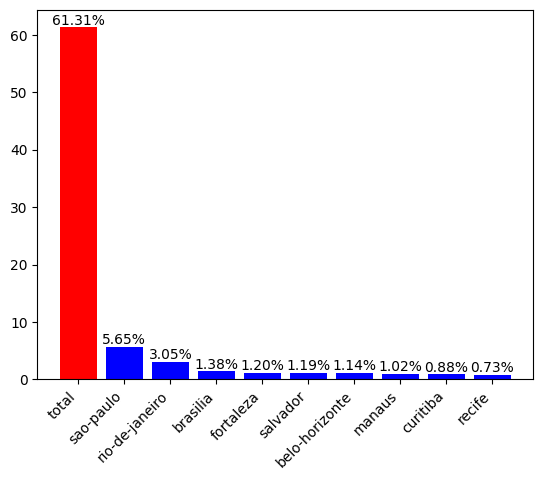

In [29]:
# Barplot of the population percentage per city and the total
fig,ax=plt.subplots()
highlight_city='total'
colors = ['red' if city == highlight_city else 'blue' for city in subw_data_city_top['city']]
bars=ax.bar(x=subw_data_city_top['city'],height=subw_data_city_top['percentage_pop'],color=colors)
ax.set_xticklabels(subw_data_city_top['city'], rotation=45, ha='right')
ax.bar_label(bars, fmt='%.2f%%')

plt.show()

### Percentage of the population to be covered

In [30]:
# Function to calculate the accumulated percentage
def acum_per(data):
    result=[]
    acum=0
    for i in data:
        acum += i
        result.append(acum)
        return result

In [31]:
# Groupby the cities that subway does not have restaurant 
subw_data_not_city = subw_data_city.merge(pob_city_acot,how='right',left_on='city',right_on='nm_mun')
subw_data_not_city=subw_data_not_city[subw_data_not_city['city'].isna()]
subw_data_not_city.sort_values(by='percentage_pop',ascending=False,inplace=True)
subw_data_not_city['acum_per']=subw_data_not_city['percentage_pop'].cumsum()
total=pd.DataFrame({'nm_mun':'total','percentage_pop':[subw_data_not_city['percentage_pop'].sum()]})
subw_data_not_city_pop=pd.concat([subw_data_not_city,total])
subw_data_not_city_pop_top=subw_data_not_city_pop.sort_values(by='percentage_pop',ascending=False).head(10)
subw_data_not_city_pop_top

,city,code,nm_mun,quantidade_de_moradores,percentage_pop,acum_per
0,NaN,NaN,total,NaN,38.687871,NaN
3191,NaN,NaN,campos-dos-goytacazes,481621.0,0.237765,0.237765
934,NaN,NaN,caucaia,355564.0,0.175534,0.413299
264,NaN,NaN,santarem,330355.0,0.163089,0.576388
1162,NaN,NaN,mossoro,263729.0,0.130197,0.706584
994,NaN,NaN,maracanau,234474.0,0.115754,0.822339
1652,NaN,NaN,arapiraca,234359.0,0.115698,0.938037
3213,NaN,NaN,mage,227170.0,0.112149,1.050185
5090,NaN,NaN,viamao,224095.0,0.110631,1.160816
3215,NaN,NaN,marica,197175.0,0.097341,1.258156


In [32]:
subw_data_not_city_pop_top=subw_data_not_city_pop_top.drop(['city','code'],axis=1)

C:\Users\Santiago\AppData\Local\Temp\ipykernel_19036\2410158405.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subw_data_not_city_pop_top['nm_mun'], rotation=45, ha='right')


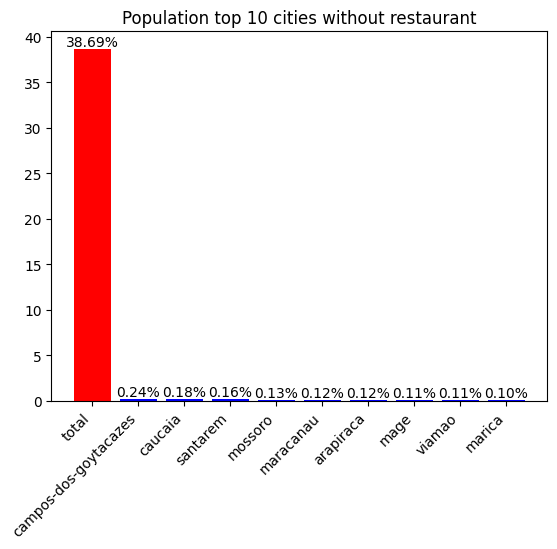

In [33]:
# Plot of the population percentage where subway does not have restaurant
fig,ax=plt.subplots()
highlight_city='total'
colors = ['red' if city == highlight_city else 'blue' for city in subw_data_not_city_pop_top['nm_mun']]
bars=ax.bar(x=subw_data_not_city_pop_top['nm_mun'],height=subw_data_not_city_pop_top['percentage_pop'],color=colors)
ax.set_xticklabels(subw_data_not_city_pop_top['nm_mun'], rotation=45, ha='right')
ax.bar_label(bars, fmt='%.2f%%')
ax.set_title('Population top 10 cities without restaurant')
plt.show()

### Percentage Accumulated

In [34]:
# Percentage accummulated of the top 10 cities where Subway does not have restaurant
subw_data_not_city_2 = subw_data_not_city[subw_data_not_city['acum_per']<2.008]

C:\Users\Santiago\AppData\Local\Temp\ipykernel_19036\1185418363.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subw_data_not_city_2['nm_mun'], rotation=45, ha='right')


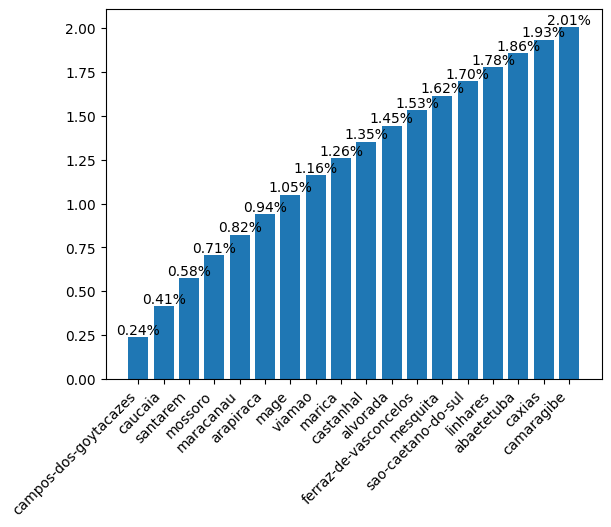

In [35]:
fig,ax=plt.subplots()
bars=ax.bar(x=subw_data_not_city_2['nm_mun'],height=subw_data_not_city_2['acum_per'])
ax.set_xticklabels(subw_data_not_city_2['nm_mun'], rotation=45, ha='right')
ax.bar_label(bars, fmt='%.2f%%')

plt.show()

Based on the analysis made, currently subway is covering **61.31%** of Brasil Population and to get to an additional 2% of the population, Subway has to open new branches in the cities shown in the bar chart. This cities were sorted from the highest population percentage to the least population percentage, so when the accumulated percentage reaches 2%, the list of cities are taken to open new restaurants.  
The list of cities is the following:  
campos-dos-goytacazes, caucaia, santarem, mossoro, maracanau, arapiraca, mage, viamao, marica, castanhal, alvorada, ferraz-de-vasconcelos, mesquita, sao-caetano-do-sul, linhares, abaetetuba, caxias, camaragibe.  
In total it would be **18** within the cities.

### Map of the branches

In [36]:
# Function to extract coordenates
def extract_coordinates(url):
    match = re.search(r"destination=(-?\d+\.\d+),(-?\d+\.\d+)", url)
    if match:
        latitude = float(match.group(1))
        longitude = float(match.group(2))
        return latitude, longitude
    return None, None

subw_data[['latitude', 'longitude']] = subw_data['maps__link'].apply(lambda x: pd.Series(extract_coordinates(x)))

In [37]:
subw_data.to_csv('subw_data.csv',index=False)

In [38]:
# The dataset of the coordinates is merged with the population percentage
subw_data_geo = subw_data.merge(pob_city_acot,how='inner',left_on='city',right_on='nm_mun')


In [39]:
subw_data_city_pop['city']='Brasil, '+subw_data_city_pop['city']
subw_data_not_city_2['nm_mun']='Brasil, '+subw_data_not_city_2['nm_mun']

C:\Users\Santiago\AppData\Local\Temp\ipykernel_19036\2476657172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subw_data_not_city_2['nm_mun']='Brasil, '+subw_data_not_city_2['nm_mun']


In [40]:
# Function that finds the location based on the city
geolocator = Nominatim(user_agent="city_geocoder",timeout=10)
def get_coordinates(city):
    location = geolocator.geocode(city)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None
# The function is applied to the dataset with subway restaurant
subw_data_city_pop[['latitude', 'longitude']] = subw_data_city_pop['city'].apply(lambda city: pd.Series(get_coordinates(city)))


In [41]:
# The function is applied to the dataset filtered without subway restaurant
subw_data_not_city_2[['latitude', 'longitude']] = subw_data_not_city_2['nm_mun'].apply(lambda city: pd.Series(get_coordinates(city)))

C:\Users\Santiago\AppData\Local\Temp\ipykernel_19036\441739763.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subw_data_not_city_2[['latitude', 'longitude']] = subw_data_not_city_2['nm_mun'].apply(lambda city: pd.Series(get_coordinates(city)))
C:\Users\Santiago\AppData\Local\Temp\ipykernel_19036\441739763.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subw_data_not_city_2[['latitude', 'longitude']] = subw_data_not_city_2['nm_mun'].apply(lambda city: pd.Series(get_coordinates(city)))


In [42]:
#subw_data_city_pop.to_csv(output_path+'subw_data_city_pop.csv',index=False)

In [43]:
subw_data_city_pop.reset_index(drop=True,inplace=True)

In [44]:
subw_data_city_pop.dropna(inplace=True)

In [45]:
# Initialize map
m = folium.Map(
    location=[-14.2350, -51.9253],  # center around Africa
    zoom_start=4,  # dezoom
    tiles='cartodb positron'  # background style
)

for idx, row in subw_data_geo.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color='blue',
        fill=True,
        fill_opacity=0.5,
        weight=1,
        popup=f'<b>{row['name']}</b><br>Lat: {row['latitude']}<br>Lon: {row['longitude']}', 
        tooltip=row['city'] 
    ).add_to(m)
for idx, row in subw_data_city_pop.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        color='red',
        fill=True,
        radius=row['percentage_pop']*8,
        fill_opacity=0.5,
        weight=1,
        popup=f'<b>{row['city']}</b><br>Lat: {row['latitude']}<br>Lon: {row['longitude']}<br>Population:{row['percentage_pop']}', 
        tooltip=row['city'] 
    ).add_to(m)
for idx, row in subw_data_not_city_2.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        color='yellow',
        fill=True,
        radius=row['percentage_pop']*100,
        fill_opacity=0.5,
        weight=1,
        popup=f'<b>{row['nm_mun']}</b><br>Lat: {row['latitude']}<br>Lon: {row['longitude']}<br>Population:{row['percentage_pop']}', 
        tooltip=row['nm_mun']
    ).add_to(m)


legend_html = """
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 250px; height: 150px; 
                background-color: white; border:2px solid grey; z-index:9999; font-size:14px;">
        <b>Map</b><br>
        <ul>
            <li><span style="background-color: yellow; width: 20px; height: 20px; display: inline-block;"></span> City without restaurant</li>
            <li><span style="background-color: red; width: 20px; height: 20px; display: inline-block;"></span> City with restaurant</li>
            <li><span style="background-color: blue; width: 20px; height: 20px; display: inline-block;"></span> Restaurant</li>
        </ul>
    </div>
"""


m.get_root().html.add_child(folium.Element(legend_html))

m.save("mapa_bubble.html")

### Overlap with McDonalds

Percentage overlap with McDonald's within 1 km: 41.6%
Percentage overlap with McDonald's within 5 km: 72.12307692307692%
Percentage overlap with McDonald's within 10 km: 78.0923076923077%
Few Subway locations overlap with McDonald's within 1 km. Opportunity for growth.
High competition in 5 km zones. Consider targeting less competitive areas.
High competition in 10 km zones. Focus on underserved locations.


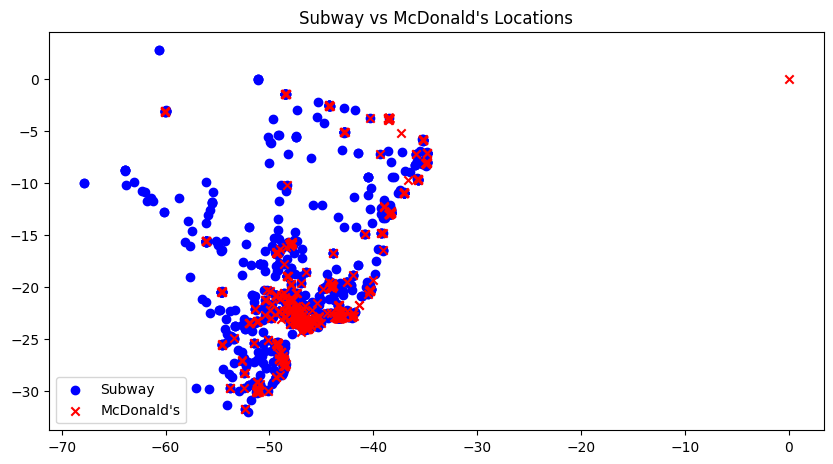

In [46]:
# Calculation of the locations overlaped 
subway=subw_data[['name','latitude','longitude']]
mcdonalds=mc_data[['name','latitude','longitude']]

subway_gdf = gpd.GeoDataFrame(subway, 
                               geometry=gpd.points_from_xy(subway.longitude, subway.latitude))

mcdonalds_gdf = gpd.GeoDataFrame(mcdonalds, 
                                  geometry=gpd.points_from_xy(mcdonalds.longitude, mcdonalds.latitude))

def calculate_overlap(subway_gdf, mcdonalds_gdf, radius_km):
    overlaps = 0
    total_subways = len(subway_gdf)
    
    for _, subway in subway_gdf.iterrows():
        subway_point = subway['geometry']
        
        # Check McDonald's locations within the radius
        for _, mcdonald in mcdonalds_gdf.iterrows():
            mcdonald_point = mcdonald['geometry']
            
            # Calculate the distance in km between Subway and McDonald's locations
            distance = geodesic((subway_point.y, subway_point.x), (mcdonald_point.y, mcdonald_point.x)).km
            
            if distance <= radius_km:
                overlaps += 1
                break  # Once overlap is found, no need to check further McDonald's locations
    
    # Calculate the percentage of Subway locations that overlap
    overlap_percentage = (overlaps / total_subways) * 100
    return overlap_percentage

overlap_1km = calculate_overlap(subway_gdf, mcdonalds_gdf, 1)
overlap_5km = calculate_overlap(subway_gdf, mcdonalds_gdf, 5)
overlap_10km = calculate_overlap(subway_gdf, mcdonalds_gdf, 10)

print(f"Percentage overlap with McDonald's within 1 km: {overlap_1km}%")
print(f"Percentage overlap with McDonald's within 5 km: {overlap_5km}%")
print(f"Percentage overlap with McDonald's within 10 km: {overlap_10km}%")

if overlap_1km > 50:
    print("High competition in 1 km zones. Consider avoiding these areas.")
else:
    print("Few Subway locations overlap with McDonald's within 1 km. Opportunity for growth.")

if overlap_5km > 50:
    print("High competition in 5 km zones. Consider targeting less competitive areas.")

if overlap_10km > 50:
    print("High competition in 10 km zones. Focus on underserved locations.")

# Plot the Subway and McDonald's locations
ax = subway_gdf.plot(color='blue', marker='o', label='Subway', figsize=(10, 6))
mcdonalds_gdf.plot(ax=ax, color='red', marker='x', label="McDonald's")
plt.title("Subway vs McDonald's Locations")
plt.legend()
plt.show()


In [47]:
# Initialize map
m = folium.Map(
    location=[-14.2350, -51.9253],  # center around Africa
    zoom_start=4,  # dezoom
    tiles='cartodb positron'  # background style
)

for idx, row in subw_data_geo.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color='blue',
        fill=True,
        fill_opacity=0.5,
        weight=1,
        popup=f'<b>{row['name']}</b><br>Lat: {row['latitude']}<br>Lon: {row['longitude']}', 
        tooltip=row['city'] 
    ).add_to(m)
for idx, row in mcdonalds.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        color='red',
        fill=True,
        radius=2,
        fill_opacity=0.5,
        weight=1,
        popup=f'<b>{row['name']}</b><br>Lat: {row['latitude']}<br>Lon: {row['longitude']}<br>', 
        tooltip=row['name'] 
    ).add_to(m)



legend_html = """
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 250px; height: 150px; 
                background-color: white; border:2px solid grey; z-index:9999; font-size:14px;">
        <b>Map</b><br>
        <ul>
            <li><span style="background-color: blue; width: 20px; height: 20px; display: inline-block;"></span> Subway</li>
            <li><span style="background-color: red; width: 20px; height: 20px; display: inline-block;"></span> McDonalds</li>
        </ul>
    </div>
"""

# Añadir la leyenda al mapa
m.get_root().html.add_child(folium.Element(legend_html))

m.save("overlap_map.html")

- Percentage overlap with McDonald's within 1 km: 41.6%
- Percentage overlap with McDonald's within 5 km: 72.12307692307692%
- Percentage overlap with McDonald's within 10 km: 78.0923076923077%
- Few Subway locations overlap with McDonald's within 1 km. Opportunity for growth.
- High competition in 5 km zones. Consider targeting less competitive areas.
- High competition in 10 km zones. Focus on underserved locations.

### Social Sentiment

Sentiment analysis is made making a web scrapping of the links of each restaurant to get the rating.

In [48]:
def rating_sentiment(url):
    response = requests.get(url)
    response.raise_for_status()  # Raise an error for failed requests
    soup = BeautifulSoup(response.text, 'lxml')
    # Extracting all rating values
    ratings = [float(rating.text.strip()) for rating in soup.find_all('strong', class_='rating-value')]

    # Calculate the mean
    mean_rating = np.mean(ratings)

    return mean_rating


In [49]:
subw_data_sentiment=subw_data_geo.sort_values(by='percentage_pop',ascending=False).head(700)

In [50]:
subw_data_sentiment['rating']=subw_data_sentiment['restaurant__link'].apply(rating_sentiment)

c:\Users\Santiago\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Santiago\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [51]:
subw_data_sentiment_gr=subw_data_sentiment.groupby(['city'],as_index=False)['rating'].mean()

In [52]:
subw_data_sentiment_gr[['latitude', 'longitude']] = subw_data_sentiment_gr['city'].apply(lambda city: pd.Series(get_coordinates(city)))

In [53]:
# Initialize map
m = folium.Map(
    location=[-14.2350, -51.9253],  # center around Africa
    zoom_start=4,  # dezoom
    tiles='cartodb positron'  # background style
)

for idx, row in subw_data_sentiment_gr.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['rating']*2,
        color='blue',
        fill=True,
        fill_opacity=0.5,
        weight=1,
        popup=f'<b>{row['city']}</b><br>Lat: {row['latitude']}<br>Lon: {row['longitude']}', 
        tooltip=row['city'] 
    ).add_to(m)


m.save("map_sentiment.html")

In [54]:
subw_data_sentiment_gr=subw_data_sentiment_gr[subw_data_sentiment_gr['city']!='cuiaba']
total_subw=pd.DataFrame({'city':'Total','rating':[subw_data_sentiment_gr['rating'].mean()]})
subw_data_sentiment_gr=pd.concat([subw_data_sentiment_gr,total_subw])

In [55]:
with pd.ExcelWriter('output.xlsx', engine='openpyxl') as writer:
    subw_data_sentiment_gr.to_excel(writer,sheet_name='subw_data_sentiment_gr',index=False)
    subw_data_city_top.to_excel(writer,sheet_name='subw_data_city_top',index=False)
    subw_data_not_city_pop_top.to_excel(writer,sheet_name='subw_data_not_city_pop_top',index=False)
    subw_data_geo.to_excel(writer,sheet_name='subw_data_geo',index=False)
    subway_gdf.to_excel(writer,sheet_name='subway_gdf',index=False)
    mcdonalds_gdf.to_excel(writer,sheet_name='mcdonalds_gdf',index=False)
    subw_data_city_pop.to_excel(writer,sheet_name='subw_data_city_pop',index=False)
    subw_data_not_city_2.to_excel(writer,sheet_name='subw_data_not_city_2',index=False)
    

C:\Users\Santiago\AppData\Local\Temp\ipykernel_19036\2745757233.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(subw_data_sentiment_gr['city'],rotation=90)


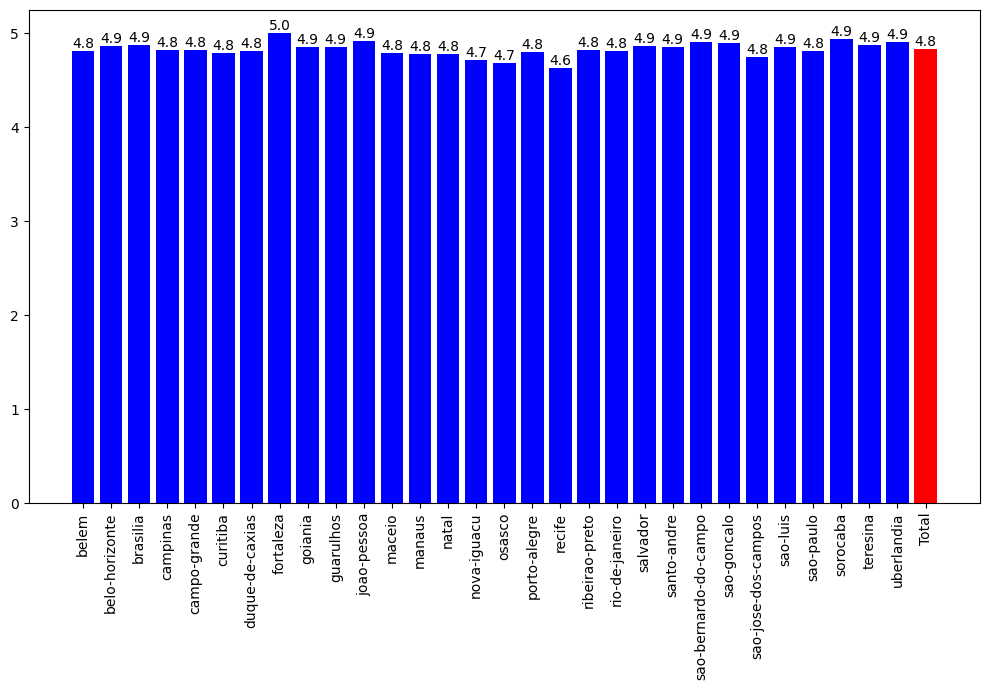

In [56]:
fig2,ax2=plt.subplots(figsize=(10,7))
colors = ['red' if city == 'Total' else 'blue' for city in subw_data_sentiment_gr['city']]
bars=ax2.bar(subw_data_sentiment_gr['city'],subw_data_sentiment_gr['rating'],color=colors)
for bar in bars:
    height = bar.get_height()  #
    ax2.text(
        bar.get_x() + bar.get_width() / 2, 
        height + 0,  
        f'{height:.1f}',  
        ha='center', va='bottom', fontsize=10, color='black'
    )
ax2.set_xticklabels(subw_data_sentiment_gr['city'],rotation=90)
plt.tight_layout()
fig2.savefig('sentiment_top_bar.png')


In conclusion, we see the main cities with an average of 4.9 of rating wich is excelent performance.

## Summary

- Currently the brand is geting to 61 % of brazil, however, building restaurants in other cities with the highest population is needed to get to the additional 2% of brazil's population.

- To stay away from the competence, Subway could build restaurants in the north-east and east of brazil in order to get good sales and don't overlap with McDonalds.

- Lastly, Subway must keep the performance of their main restaurants, therefore restaurants in cities such as Sao Paulo, Brasilia, Belo Horizonte, Rio de Janeiro and so on, will get more sales and bring satisfaction tu the customers.